# Stock Market Prediction

# I. Packages

In [11]:
# read in the packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils as ut
from importlib import reload
reload(ut)
import plotly.graph_objects as go
import matplotlib as mpl

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# set pandas options 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 999)

# II. Data Exploration
## II. 1. Find the ticker symbol for the comany which closing stock price we want to predict
**dataset**: US Stocks & ETFs - Tickers, Company Info, Logos <br>

We can search for companies, whose stock price we want to predict. <br>

For example, I am going to select a company based on its industry.

In [12]:
df_us_stocks = pd.read_csv('data/companies.csv')
# we won't need this kind of data for finding the ticker we need, so we get rid of them 
df_us_stocks = df_us_stocks.drop(['website', 'logo',  'ceo'], axis = 1) 
df_us_stocks.sample(5)

,ticker,company name,short name,industry,description,exchange,market cap,sector,tag 1,tag 2,tag 3
2412,GIG,GigCapital Inc.,GigCapital,Conglomerates,"GigCapital Inc is a blank check company. The company was formed for the purpose of effecting a merger, capital stock exchange, asset acquisition, stock purchase, reorganization or similar business combination with one or more businesses.",New York Stock Exchange,1.877586e+08,Industrials,Industrials,Conglomerates,NaN
278,AMTB,Mercantil Bank Holding Corporation,Mercantil Bank Holding,Banks,NaN,Nasdaq Global Select,6.054257e+08,Financial Services,Financial Services,Banks - Regional - US,Banks
1706,ECOR,electroCore Inc.,electroCore,Medical Instruments & Equipment,Electrocore Inc is a commercial-stage bioelectronic medicine company with a platform for non-invasive vagus nerve stimulation therapy initially focused on neurology and rheumatology.,Nasdaq Global Select,2.017327e+08,Healthcare,Healthcare,Medical Instruments & Supplies,Medical Instruments & Equipment
4938,RXD,ProShares UltraShort Health Care,ProShares UltraShort Health Care,NaN,"The investment seeks daily investment results, before fees and expenses, that correspond to two times the inverse (-2x) of the daily performance of the Dow Jones U.S. Health CareSM Index.\n The fund invests in financial instruments that ProShare Advisors believes, in combination, should produce daily returns consistent with the fund's investment objective. The index seeks to measure the performance of certain companies in the healthcare sector of the U.S. equity market. The fund is non-diversified.",NYSE Arca,2.536397e+06,NaN,NaN,NaN,NaN
3913,NEE,NextEra Energy Inc.,NextEra Energy,Utilities - Regulated,"NextEra Energy Inc is an electric power company in North America. It generates renewable energy from wind and sun. The company also owns generation, transmission and distribution facilities and has investments in gas infrastructure assets.",New York Stock Exchange,8.476359e+10,Utilities,Utilities,Utilities - Regulated Electric,Utilities - Regulated


In [13]:
df_us_stocks['industry'].unique()

array(['Medical Diagnostics & Research', 'Metals & Mining',
       'Asset Management', 'Health Care Providers', nan, 'Airlines',
       'Insurance - Life', 'Consulting & Outsourcing', 'Semiconductors',
       'Building Materials', 'Retail - Apparel & Specialty',
       'Computer Hardware', 'REITs', 'Transportation & Logistics',
       'Aerospace & Defense', 'Industrial Products', 'Drug Manufacturers',
       'Medical Distribution', 'Banks', 'Biotechnology',
       'Beverages - Alcoholic', 'Autos', 'Communication Equipment',
       'Business Services', 'Medical Devices', 'Brokers & Exchanges',
       'Engineering & Construction', 'Insurance', 'Application Software',
       'Consumer Packaged Goods', 'Credit Services', 'Waste Management',
       'Oil & Gas - Integrated', 'Utilities - Regulated',
       'Insurance - Property & Casualty', 'Farm & Construction Machinery',
       'Agriculture', 'Insurance - Specialty', 'Travel & Leisure',
       'Publishing', 'Homebuilding & Construction',
 

In [14]:
df_us_stocks[df_us_stocks['industry'] == 'Oil & Gas - Drilling'].sort_values(by='market cap', ascending=False).head(5)

,ticker,company name,short name,industry,description,exchange,market cap,sector,tag 1,tag 2,tag 3
2714,HP,Helmerich & Payne Inc.,Helmerich & Payne,Oil & Gas - Drilling,"Helmerich & Payne Inc is engaged in contract drilling of oil and gas wells for oil and gas exploration and production companies. Its business comprises of three reportable segments, U.S. Land, Offshore and International Land.",New York Stock Exchange,6.247044e+09,Energy,Energy,Oil & Gas Drilling,Oil & Gas - Drilling
4830,RIG,Transocean Ltd (Switzerland),Transocean (Switzerland),Oil & Gas - Drilling,"Transocean Ltd is an international provider of offshore contract drilling services for oil and gas wells. Its business activities include contracting drilling rigs, related equipment and work crews to drill oil and gas wells.",New York Stock Exchange,5.355144e+09,Energy,Energy,Oil & Gas Drilling,Oil & Gas - Drilling
4611,PTEN,Patterson-UTI Energy Inc.,Patterson-UTI Energy,Oil & Gas - Drilling,"Patterson-UTI Energy Inc is a North America-based land rig drilling contractors. It operates in three segments namely, Contract Drilling Services, Pressure Pumping Services, and Oil and Natural Gas Exploration and Production.",Nasdaq Global Select,2.780719e+09,Energy,Energy,Oil & Gas Drilling,Oil & Gas - Drilling
1916,ESV,Ensco plc Class A,Ensco plc,Oil & Gas - Drilling,"Ensco PLC provides offshore contract drilling services to national and international oil companies as well as independent operators. It operates its business in U.S. Gulf of Mexico, Mexico, Brazil, the Mediterranean, and the North Sea.",New York Stock Exchange,2.031107e+09,Energy,Energy,Oil & Gas Drilling,Oil & Gas - Drilling
4760,RDC,Rowan Companies plc Class A,Rowan Companies plc,Oil & Gas - Drilling,Rowan Companies PLC is an offshore drilling contractor firm. The company engages in drilling oil and gas properties on contractual basis and mainly serves the petroleum industry.,New York Stock Exchange,1.625210e+09,Energy,Energy,Oil & Gas Drilling,Oil & Gas - Drilling


In [15]:
selected_company_ticker = 'HP' #Helmerich & Payne
company_name = df_us_stocks[df_us_stocks['ticker'] == selected_company_ticker].iloc[0]['short name']


# II. 2. Explore the Stock Market Dataset
**dataset:** Huge Stock Market Dataset<br>

- there are some days where we have no data - stock market was closed on these days 

In [16]:
# Read in the data 
zip_file_path = 'data/huge_stock_market_data.zip'
company_ticker = 'hp.us.txt' # company ticker format should be: companyticker.us.txt
date_interval = ['2014-01-01', '2016-12-31']

In [17]:
df_stock_market = ut.read_huge_market_stock_data(zip_file_path, company_ticker, date_interval)
df_stock_market.sample(5)

File is already unzipped


,Date,Open,High,Low,Close,Volume,OpenInt
2465,2014-12-11,54.117,55.778,53.311,53.588,2901951,0
2271,2014-03-07,85.882,85.995,84.634,85.545,1218224,0
2758,2016-02-11,41.815,42.699,40.751,42.083,3338165,0
2501,2015-02-04,57.377,59.470,55.788,57.107,5790299,0
2280,2014-03-20,87.110,88.888,87.050,88.694,1142713,0


In [18]:
df_stock_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756 entries, 2227 to 2982
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     756 non-null    datetime64[ns]
 1   Open     756 non-null    float64       
 2   High     756 non-null    float64       
 3   Low      756 non-null    float64       
 4   Close    756 non-null    float64       
 5   Volume   756 non-null    int64         
 6   OpenInt  756 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 47.2 KB


### II.2.1. Closing Price History
We should take a quick look at the history of the company"s closing price history.

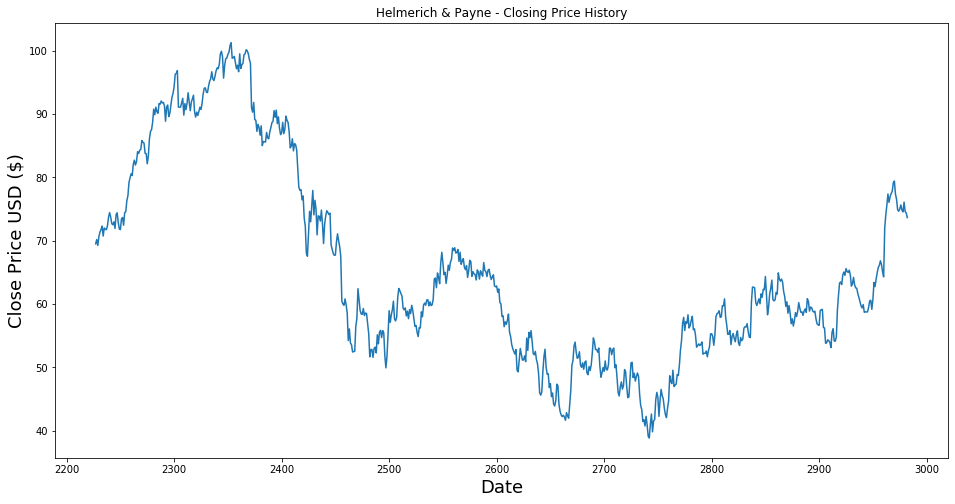

In [19]:
ut.plot_closing_price_history(df_stock_market['Close'], company_name)

### II.2.2. Exponential Moving Average

In [20]:
# calcualte EMA for the last 60 days
df_stock_market['EMA_60'] = df_stock_market.iloc[:,3].ewm(span=60,adjust=False).mean()

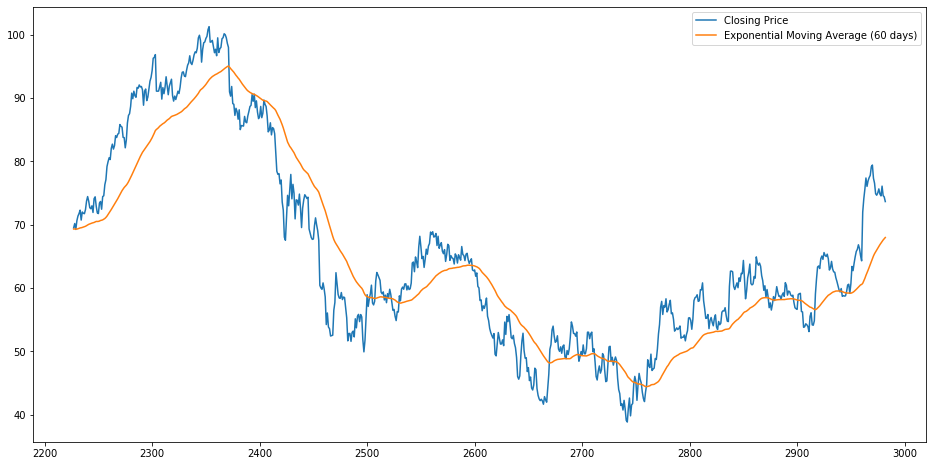

In [21]:
# plot closing price and moving average
plt.figure(figsize=(16, 8))
plt.plot(df_stock_market['Close'], label='Closing Price')
plt.plot(df_stock_market['EMA_60'], label='Exponential Moving Average (60 days)')
plt.legend()


# III. Data preparation

**1. Converting the data into array.**

In [22]:
# Create a new dataframe with only the 'Close' column
data = df_stock_market.filter(['Close'])
# converting the dataframe to a numpy array
dataset = data.values

**2. Scaling the data.**

In [23]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)


**3. creating train & test data**

The train and test sets are going to contain moving values. 

**training set**: containing the past 60 day closing price values<br>
**test_set**: closing price on the 61st day 

We should store the training data length into a separate variable as we are not neccesseraly 
have data for each day and we are going to need this later.
- we will need this for plotting

In [24]:
training_data_len, x_train, y_train, x_test, y_test = ut.create_train_test_split(.8, 60, dataset, scaled_data)    

**4. preparing data sets for LSTM **
LSTM is expecting a 3D dataset: [number of samples, number of time steps, and number of features]


In [25]:
x_train, y_train = ut.create_3D_arrays(x_train, y_train)
x_test, y_test = ut.create_3D_arrays(x_test, y_test)


#IV. modelling 


In [26]:
#Build the LSTM  model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
545/545 [==============================] - 40s 73ms/step - loss: 0.0065

V. Prediction

In [27]:
# Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [28]:
# Calculate RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

5.812913243215893

D:\Bea\Projects\github\stock_price_prediction\utils.py:127: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



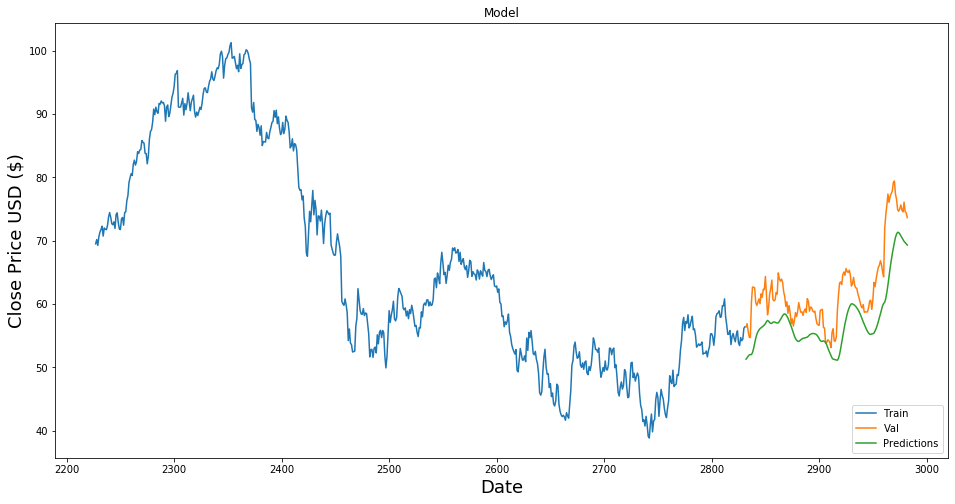

In [29]:
ut.plot_result(data, training_data_len, predictions)